In [1]:
import torch
from torch import optim
import torch.nn as nn
import numpy as np
import pandas as pd
import os
from torch.utils.data.dataset import IterableDataset
from torch.utils.data import DataLoader
from tqdm import tqdm
# from audtorch.metrics.functional import *
import shutil
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

In [20]:
class MyModel(nn.Module):
    def __init__(
            self,
            input_dim: int =1,
            hidden_dim: int = 15,
            output_dim: int = 2):
        super().__init__()
        self.gru1 = nn.GRU(input_dim, hidden_dim, batch_first=True, num_layers=1)
        self.gru2 = nn.GRU(16, hidden_dim, batch_first=True, num_layers=1)
        #self.hidden = nn.BatchNorm1d(hidden_dim)
        self.linear = nn.Linear(hidden_dim, output_dim)

    def forward(self, x1):
        # (bat_size, seq, features)
        l_x1, _ = self.gru1(x1[:,  :, 769:770])
        l_x1 = l_x1[:, -1, :] #(bat_size, features)
        #print(l_x1.shape)
        #combined_input = torch.cat((l_x1, x1[:, :, 769:770]), dim=2) # 连接在特征维度上
        #print(x1[:, :, 769:770].shape)
        #print(combined_input.shape)
        #l_x2, _ = self.gru2(combined_input)
        #l_x2 = l_x2[:, -1, :] #(bat_size, features)
        #print(l_x2.shape)
        #hidden = self.hidden(l_x1)
        #print(hidden.shape)
        output = self.linear(l_x1)
        #print(output.shape)
        return output

In [3]:
class MyModel(nn.Module):
    def __init__(
            self,
            input_dim: int =769,
            hidden_dim: int = 15,
            output_dim: int = 2):
        super().__init__()
        self.gru1 = nn.GRU(input_dim, hidden_dim, batch_first=True, num_layers=1)
        self.gru2 = nn.GRU(1, hidden_dim, batch_first=True, num_layers=1)
        self.gru3 = nn.GRU(30, hidden_dim, batch_first=True, num_layers=1)
        
        self.hidden = nn.BatchNorm1d(hidden_dim)
        self.linear = nn.Linear(hidden_dim, output_dim)

    def forward(self, x1):
        # (bat_size, seq, features)
        l_x1, _ = self.gru1(x1[:, :, :769])
        #l_x1 = l_x1[:, :, :] #(bat_size, features)
        #print(l_x1.shape)
        l_x2, _ = self.gru2(x1[:, :, 769:770])
        combined_input = torch.cat((l_x1, l_x2), dim=2) # 连接在特征维度上
        #print(x1[:, :, 769:770].shape)
        #print(combined_input.shape)
        l_x3, _ = self.gru3(combined_input)
        l_x3 = l_x3[:, -1, :] #(bat_size, features)
        #print(l_x2.shape)
        hidden = self.hidden(l_x3)
        #print(hidden.shape)
        output = self.linear(hidden)
        #print(output.shape)
        return output

In [4]:
class MyModel(nn.Module):
    def __init__(
            self,
            input_dim: int =769,
            hidden_dim: int = 15,
            output_dim: int = 2):
        super().__init__()
        self.gru1 = nn.GRU(input_dim, hidden_dim, batch_first=True, num_layers=1)
        self.hidden = nn.BatchNorm1d(hidden_dim)
        self.linear = nn.Linear(30, output_dim)

    def forward(self, x1):
        # (bat_size, seq, features)
        l_x1, _ = self.gru1(x1[:, :, :769])
        l_x1 = l_x1[:, -1, :] #(bat_size, features)
        #print(l_x1.shape)
        hidden = self.hidden(l_x1)
        #print(hidden.shape)
        combined_input = torch.cat((hidden, x1[:, :, 769]), dim=1) # 连接在特征维度上
        #print(combined_input.shape)
        #print(hidden.shape)
        
        output = self.linear(combined_input)
        #print(output.shape)
        return output

In [5]:
class Mydataset(IterableDataset):
    def __init__(self,data1, label) -> None:
            super().__init__()
            self.data1 = data1.astype(np.float32)
            self.label = label.astype(np.float32)
    def __len__(self):
        return len(self.data1)
    def __iter__(self):
        for row in range(len(self.data1)):
            yield self.data1[row], self.label[row]

In [6]:
import pickle
import numpy as np

# 定义 pickle 文件名列表
pickle_files = ['/mnt/weka/home/test/yujichong_share/data/fxs/2019_output.pkl', ]#'data/default/2021_3_output.pkl', 'data/default/2021_4_output.pkl', ]#'data/default/2021_5_output.pkl', 'data/default/2021_6_output.pkl', 'data/default/2021_7_output.pkl', 'data/default/2021_8_output.pkl']

# 初始化 concatenated_array
with open(pickle_files[0], 'rb') as f:
    X1 = pickle.load(f)
    X1 = np.nan_to_num(X1, nan=0)
# 循环遍历 pickle 文件名列表，逐个导入 pickle 文件
for file in pickle_files[1:]:
    with open(file, 'rb') as f:
        data = pickle.load(f)
        data = np.nan_to_num(data, nan=0)
        X1 = np.concatenate((X1, data), axis=1)
        print(X1.shape)
# 打印导入的数据列表
X1 = X1.sum(axis=0)
print(X1.shape)

(244, 242, 769)


In [7]:
import pickle
import numpy as np

# 定义 pickle 文件名列表
pickle_files = ['/mnt/weka/home/test/yujichong_share/data/fxs/2020_output.pkl',]#'data/default/2021_5_output.pkl', 'data/default/2021_6_output.pkl', 'data/default/2021_7_output.pkl', 'data/default/2021_8_output.pkl']

# 初始化 concatenated_array
with open(pickle_files[0], 'rb') as f:
    X2 = pickle.load(f)
    X2 = np.nan_to_num(X2, nan=0)
# 循环遍历 pickle 文件名列表，逐个导入 pickle 文件
for file in pickle_files[1:]:
    with open(file, 'rb') as f:
        data = pickle.load(f)
        data = np.nan_to_num(data, nan=0)
        X2 = np.concatenate((X2, data), axis=1)
        print(X2.shape)
# 打印导入的数据列表
X2 = X2.sum(axis=0)
print(X2.shape)

(243, 242, 769)


In [8]:
import pickle
import numpy as np

# 定义 pickle 文件名列表
pickle_files = ['/mnt/weka/home/test/yujichong_share/data/fxs/2021_output.pkl',]# 'data/default/2021_7_output.pkl', 'data/default/2021_8_output.pkl']

# 初始化 concatenated_array
with open(pickle_files[0], 'rb') as f:
    X3 = pickle.load(f)
    X3 = np.nan_to_num(X3, nan=0)
# 循环遍历 pickle 文件名列表，逐个导入 pickle 文件
for file in pickle_files[1:]:
    with open(file, 'rb') as f:
        data = pickle.load(f)
        data = np.nan_to_num(data, nan=0)
        X3 = np.concatenate((X3, data), axis=1)
        print(X3.shape)
# 打印导入的数据列表
X3 = np.nan_to_num(X3, nan=0)
X3 = X3.sum(axis=0)
print(X3.shape)

(243, 242, 769)


In [9]:
import pickle
import numpy as np

# 定义 pickle 文件名列表
pickle_files = ['/mnt/weka/home/test/yujichong_share/data/fxs/2022_output.pkl' , ]

# 初始化 concatenated_array
with open(pickle_files[0], 'rb') as f:
    X4 = pickle.load(f)
    X4 = np.nan_to_num(X4, nan=0)
# 循环遍历 pickle 文件名列表，逐个导入 pickle 文件
for file in pickle_files[1:]:
    with open(file, 'rb') as f:
        data = pickle.load(f)
        data = np.nan_to_num(data, nan=0)
        X4 = np.concatenate((X4, data), axis=1)
        print(X4.shape)
# 打印导入的数据列表
X4 = np.nan_to_num(X4, nan=0)
X4 = X4.sum(axis=0)
print(X4.shape)

(242, 242, 769)


In [10]:
X = np.concatenate((X1, X2, X3, X4), axis=0)
#242变60版本
#X=X[:,:240,:]
#X_agg = X.sum(axis=1).reshape((243, 60, 769))
#X = np.concatenate([X[:, i:i+4, :].sum(axis=1, keepdims=True) for i in range(0, 242, 4)], axis=1)
X = np.delete(X, 120, axis=1)
X=X[:,:225,:]
X.shape


(972, 225, 769)

In [11]:
n_sample = 0
len_minute=15
x0 = np.zeros(
    (int(X.shape[0] * (X.shape[1] -len_minute+1)), len_minute, X.shape[2]))
for i in range(0, X.shape[0]):
    #for j in range(0,X.shape[1] -len_minute+1,5):
    for j in range(0,X.shape[1] -len_minute+1):
        x1_one = X[i, j:j + len_minute]
        x0[n_sample, :, :] = x1_one
        n_sample += 1
    e_index = n_sample
x0 = x0[:n_sample, :]
#x0=x0[102757:, :]
#x0=x0[51484:, :]
#x0=x0[20941:, :]
#x0=x0[10492:, :]
x0.shape

(205092, 15, 769)

In [12]:
import datetime
import logging
logging.disable(logging.CRITICAL)
from higgsboom.MarketData.DDBSecurityMarketDataUtils import *


DDBSUtils=DDBSecurityMarketDataUtils(config={"Cluster":"Research",
                      "UserName":"maming",
                      "Password":"passwd123456"})

hs_min_df=DDBSUtils.IndexMinuteDataFrame('000300.SH','20190101','20230105',dataSource="TAQ")
hs_min_df
hs_min_df['hsshan0925'] = hs_min_df.groupby('TRADING_DATE')['CLOSE'].apply(lambda x: x / x.shift(1) - 1)
hs_min_df = hs_min_df[hs_min_df['hsshan0925'].notna()]
hs_min_df=hs_min_df.drop('hsshan0925', axis=1)


hs_min_df['return'] = hs_min_df.groupby('TRADING_DATE')['CLOSE'].apply(lambda x: x / x.shift(15) - 1)
#idx_min_df['return']=idx_min_df['return'].shift(-16)

hs_min_df
# #量价因子构造
# df_liangjia=idx_min_df.copy()
# #变成5min
hs_min_df['return1'] = hs_min_df.groupby('TRADING_DATE')['CLOSE'].apply(lambda x: x / x.shift(5) - 1)
#idx_min_df.iloc[:1000].to_csv('grumoxing.csv')
#idx_min_df
# #对Y矩阵构造
hs_min_df['return'] = hs_min_df.groupby('TRADING_DATE')['return'].shift(-30)
hs_min_df['return1'] = hs_min_df.groupby('TRADING_DATE')['return1'].shift(-20)
#idx_min_df.iloc[:1000].to_csv('grumoxing.csv')
#idx_min_df
hs_min_df = hs_min_df[hs_min_df['TRADING_DATE'] < '2023-01-01']
hs_min_df = hs_min_df[hs_min_df['return'].notna()]
hs_min_df['return_up_down'] = hs_min_df['return1'].apply(lambda x: 1 if x > 0 else 0)
hs_min_df
#降低采样频率
# def select_first_in_every_five(df):
#     return df.iloc[::5]
# idx_min_df = idx_min_df.groupby('TRADING_DATE').apply(select_first_in_every_five)
# idx_min_df=idx_min_df.reset_index(drop=True)
#idx_min_df
#选择时间区间
#idx_min_df= idx_min_df[idx_min_df['TRADING_DATE'] > '2020-12-31']
#idx_min_df
Yhs = hs_min_df.pivot(index='SYMBOL', columns='TRADING_TIME', values='return_up_down').to_numpy().T
print(Yhs.shape)

/tmp/ipykernel_2954478/258714747.py:11: DeprecationWarning: Call to deprecated method IndexMinuteDataFrame. (This function will be deprecated in version 2.0. Use func index_min_data in higgsboom.data.market.cnsecurity.CNSecurityMarketDataUtils instead.)
  hs_min_df=DDBSUtils.IndexMinuteDataFrame('000300.SH','20190101','20230105',dataSource="TAQ")


(205092, 1)


In [13]:
import datetime
import logging
logging.disable(logging.CRITICAL)
from higgsboom.MarketData.DDBSecurityMarketDataUtils import *


DDBSUtils=DDBSecurityMarketDataUtils(config={"Cluster":"Research",
                      "UserName":"maming",
                      "Password":"passwd123456"})

idx1000_min_df=DDBSUtils.IndexMinuteDataFrame('000852.SH','20190101','20230105',dataSource="TAQ")
idx1000_min_df['idx1000shan0925'] = idx1000_min_df.groupby('TRADING_DATE')['CLOSE'].apply(lambda x: x / x.shift(1) - 1)
idx1000_min_df = idx1000_min_df[idx1000_min_df['idx1000shan0925'].notna()]
idx1000_min_df=idx1000_min_df.drop('idx1000shan0925', axis=1)


idx1000_min_df['return'] = idx1000_min_df.groupby('TRADING_DATE')['CLOSE'].apply(lambda x: x / x.shift(15) - 1)
#idx_min_df['return']=idx_min_df['return'].shift(-16)

idx1000_min_df
# #量价因子构造
# df_liangjia=idx_min_df.copy()
# #变成5min
idx1000_min_df['return1'] = idx1000_min_df.groupby('TRADING_DATE')['CLOSE'].apply(lambda x: x / x.shift(5) - 1)
#idx_min_df.iloc[:1000].to_csv('grumoxing.csv')
#idx_min_df
# #对Y矩阵构造
idx1000_min_df['return'] = idx1000_min_df.groupby('TRADING_DATE')['return'].shift(-30)
idx1000_min_df['return1'] = idx1000_min_df.groupby('TRADING_DATE')['return1'].shift(-20)
#idx_min_df.iloc[:1000].to_csv('grumoxing.csv')
#idx_min_df
idx1000_min_df = idx1000_min_df[idx1000_min_df['TRADING_DATE'] < '2023-01-01']
idx1000_min_df = idx1000_min_df[idx1000_min_df['return'].notna()]
idx1000_min_df['return_up_down'] = idx1000_min_df['return1'].apply(lambda x: 1 if x > 0 else 0)
idx1000_min_df
#降低采样频率
# def select_first_in_every_five(df):
#     return df.iloc[::5]
# idx_min_df = idx_min_df.groupby('TRADING_DATE').apply(select_first_in_every_five)
# idx_min_df=idx_min_df.reset_index(drop=True)
#idx_min_df
#选择时间区间
#idx_min_df= idx_min_df[idx_min_df['TRADING_DATE'] > '2020-12-31']
#idx_min_df
Yidx1000 = idx1000_min_df.pivot(index='SYMBOL', columns='TRADING_TIME', values='return_up_down').to_numpy().T
print(Yidx1000.shape)

/tmp/ipykernel_2954478/692449597.py:11: DeprecationWarning: Call to deprecated method IndexMinuteDataFrame. (This function will be deprecated in version 2.0. Use func index_min_data in higgsboom.data.market.cnsecurity.CNSecurityMarketDataUtils instead.)
  idx1000_min_df=DDBSUtils.IndexMinuteDataFrame('000852.SH','20190101','20230105',dataSource="TAQ")


(205092, 1)


In [14]:
import datetime
import logging
logging.disable(logging.CRITICAL)
from higgsboom.MarketData.DDBSecurityMarketDataUtils import *


DDBSUtils=DDBSecurityMarketDataUtils(config={"Cluster":"Research",
                      "UserName":"maming",
                      "Password":"passwd123456"})

idx_min_df=DDBSUtils.IndexMinuteDataFrame('000905.SH','20190101','20230105',dataSource="TAQ")
idx_min_df['shan0925'] = idx_min_df.groupby('TRADING_DATE')['CLOSE'].apply(lambda x: x / x.shift(1) - 1)
idx_min_df = idx_min_df[idx_min_df['shan0925'].notna()]
idx_min_df=idx_min_df.drop('shan0925', axis=1)

idx_min_df['return'] = idx_min_df.groupby('TRADING_DATE')['CLOSE'].apply(lambda x: x / x.shift(15) - 1)
#idx_min_df['return']=idx_min_df['return'].shift(-16)

idx_min_df
# #量价因子构造
df_liangjia=idx_min_df.copy()
# #变成5min
idx_min_df['return1'] = idx_min_df.groupby('TRADING_DATE')['CLOSE'].apply(lambda x: x / x.shift(5) - 1)
#idx_min_df.iloc[:1000].to_csv('grumoxing.csv')
#idx_min_df
# #对Y矩阵构造
idx_min_df['return'] = idx_min_df.groupby('TRADING_DATE')['return'].shift(-30)
idx_min_df['return1'] = idx_min_df.groupby('TRADING_DATE')['return1'].shift(-20)
#idx_min_df.iloc[:1000].to_csv('grumoxing.csv')
#idx_min_df
idx_min_df = idx_min_df[idx_min_df['TRADING_DATE'] < '2023-01-01']
idx_min_df = idx_min_df[idx_min_df['return'].notna()]
idx_min_df['return_up_down'] = idx_min_df['return1'].apply(lambda x: 1 if x > 0 else 0)
idx_min_df['return_up_down1'] = (idx_min_df['return1']-(idx_min_df['return1']+idx1000_min_df['return1']+hs_min_df['return1'])/3).apply(lambda x: 1 if x > 0 else 0)
#降低采样频率
# def select_first_in_every_five(df):
#     return df.iloc[::5]
# idx_min_df = idx_min_df.groupby('TRADING_DATE').apply(select_first_in_every_five)
# idx_min_df=idx_min_df.reset_index(drop=True)
#idx_min_df
#选择时间区间
#idx_min_df= idx_min_df[idx_min_df['TRADING_DATE'] > '2020-12-31']
#idx_min_df
Y = idx_min_df.pivot(index='SYMBOL', columns='TRADING_TIME', values='return_up_down').to_numpy().T
Y1 = idx_min_df.pivot(index='SYMBOL', columns='TRADING_TIME', values='return_up_down1').to_numpy().T
print(Y.shape)

/tmp/ipykernel_2954478/1609448231.py:11: DeprecationWarning: Call to deprecated method IndexMinuteDataFrame. (This function will be deprecated in version 2.0. Use func index_min_data in higgsboom.data.market.cnsecurity.CNSecurityMarketDataUtils instead.)
  idx_min_df=DDBSUtils.IndexMinuteDataFrame('000905.SH','20190101','20230105',dataSource="TAQ")


(205092, 1)


In [15]:
df_liangjia['ret'] = df_liangjia.groupby('TRADING_DATE')['CLOSE'].apply(lambda x: x / x.shift(1) - 1)
df_liangjia['ret'] = df_liangjia.groupby('TRADING_DATE')['ret'].shift(-1)
df_liangjia['return'] = df_liangjia.groupby('TRADING_DATE')['return'].shift(-16)
df_liangjia = df_liangjia[df_liangjia['TRADING_DATE'] < '2023-01-01']
df_liangjia = df_liangjia[df_liangjia['return'].notna()]
df_liangjia


x_liangjia = df_liangjia.groupby('TRADING_DATE').apply(lambda x: x[['ret', 'AMT']].values)
x_liangjia = x_liangjia.tolist()
x_liangjia = np.array(x_liangjia)
x_liangjia.shape

n_sample = 0
len_minute=15
x0_liangjia = np.zeros(
    (int(x_liangjia.shape[0] * (x_liangjia.shape[1] -len_minute+1)), len_minute, x_liangjia.shape[2]))
for i in range(0, x_liangjia.shape[0]):
    #for j in range(0,X.shape[1] -len_minute+1,5):
    for j in range(0,x_liangjia.shape[1] -len_minute+1):
        x1_one_liangjia = x_liangjia[i, j:j + len_minute]
        x0_liangjia[n_sample, :, :] = x1_one_liangjia
        n_sample += 1
    e_index = n_sample
x0_liangjia = x0_liangjia[:n_sample, :]
#x0_ret=x0_liangjia[:, :,:1]
#x0_amt=x0_liangjia[:, :,1:]
x0_liangjia.shape

(205092, 15, 2)

In [16]:
X_hunhe = np.concatenate((x0, x0_liangjia), axis=2)
X_hunhe.shape

(205092, 15, 771)

In [17]:
def standardize_data(x_data, med_x1, mad_x1):
    n_sample = 0
    # 遍历所有的股票样本
    for i in range(x_data.shape[0]):
        s_index = n_sample
        x1_one = x_data[i, :,:]
        n_sample += 1
        e_index = n_sample
        for k in range(0, x1_one.shape[0]):
            for s in range(0, x1_one.shape[1]):
                tmpmean = med_x1[k][s]
                tmpstd = mad_x1[k][s]
                x_data[s_index:e_index, k, s] = (x_data[s_index:e_index, k, s] - tmpmean) / (tmpstd + 1e-8)
    return x_data

(57333, 15, 771)
(57333, 1)
(47333, 15, 2)
(5000, 15, 2)
(5000, 15, 2)
(47333, 15, 771)
(5000, 15, 771)
(5000, 15, 771)
(47333, 1)
(5000, 1)
(5000, 1)
data finish


100%|██████████| 185/185 [00:00<00:00, 243.31it/s]


train acc:0.5196797160543384 train_loss:0.6919069261164279


epoch:0 val CrossEntropy:2677.0000 : 100%|██████████| 20/20 [00:00<00:00, 297.62it/s]


val acc:0.5354
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 374.20it/s]


test acc:0.5346


100%|██████████| 185/185 [00:00<00:00, 242.39it/s]


train acc:0.5369192740793949 train_loss:0.6904461348378981


epoch:1 val CrossEntropy:2657.0000 : 100%|██████████| 20/20 [00:00<00:00, 299.39it/s]


val acc:0.5314
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 363.83it/s]


test acc:0.5292


100%|██████████| 185/185 [00:00<00:00, 242.46it/s]


train acc:0.5372573046289059 train_loss:0.6902523775358458


epoch:2 val CrossEntropy:2649.0000 : 100%|██████████| 20/20 [00:00<00:00, 292.90it/s]


val acc:0.5298
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 371.12it/s]


test acc:0.5274


100%|██████████| 185/185 [00:00<00:00, 239.97it/s]


train acc:0.5381657617307164 train_loss:0.6901575413910118


epoch:3 val CrossEntropy:2637.0000 : 100%|██████████| 20/20 [00:00<00:00, 295.53it/s]


val acc:0.5274
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 365.98it/s]


test acc:0.5264


100%|██████████| 185/185 [00:00<00:00, 241.37it/s]


train acc:0.5378277311812055 train_loss:0.6900968603185705


epoch:4 val CrossEntropy:2642.0000 : 100%|██████████| 20/20 [00:00<00:00, 302.60it/s]


val acc:0.5284
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 356.72it/s]


test acc:0.5268


100%|██████████| 185/185 [00:00<00:00, 243.87it/s]


train acc:0.5373418122662835 train_loss:0.6900501138455158


epoch:5 val CrossEntropy:2638.0000 : 100%|██████████| 20/20 [00:00<00:00, 298.82it/s]


val acc:0.5276
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 369.49it/s]


test acc:0.5266


100%|██████████| 185/185 [00:00<00:00, 241.42it/s]


train acc:0.5376375889971056 train_loss:0.690009720905407


epoch:6 val CrossEntropy:2638.0000 : 100%|██████████| 20/20 [00:00<00:00, 306.43it/s]


val acc:0.5276
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 369.77it/s]


test acc:0.5266


100%|██████████| 185/185 [00:00<00:00, 239.27it/s]


train acc:0.5381868886400608 train_loss:0.6899722137966672


epoch:7 val CrossEntropy:2642.0000 : 100%|██████████| 20/20 [00:00<00:00, 303.70it/s]


val acc:0.5284
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 370.94it/s]


test acc:0.5274


100%|██████████| 185/185 [00:00<00:00, 242.02it/s]


train acc:0.5388418228297382 train_loss:0.6899357708724769


epoch:8 val CrossEntropy:2644.0000 : 100%|██████████| 20/20 [00:00<00:00, 301.01it/s]


val acc:0.5288
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 360.25it/s]


test acc:0.5278


100%|██████████| 185/185 [00:00<00:00, 241.86it/s]


train acc:0.5386305537362939 train_loss:0.6898992351583533


epoch:9 val CrossEntropy:2644.0000 : 100%|██████████| 20/20 [00:00<00:00, 304.51it/s]


val acc:0.5288
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 361.65it/s]


test acc:0.5284


100%|██████████| 185/185 [00:00<00:00, 239.51it/s]


train acc:0.5388418228297382 train_loss:0.6898619613131961


epoch:10 val CrossEntropy:2645.0000 : 100%|██████████| 20/20 [00:00<00:00, 288.37it/s]


val acc:0.529
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 337.93it/s]


test acc:0.529


100%|██████████| 185/185 [00:00<00:00, 236.33it/s]


train acc:0.5394122493820379 train_loss:0.6898234518798622


epoch:11 val CrossEntropy:2641.0000 : 100%|██████████| 20/20 [00:00<00:00, 302.70it/s]


val acc:0.5282
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 326.46it/s]


test acc:0.5282


100%|██████████| 185/185 [00:00<00:00, 238.30it/s]


train acc:0.5396657722941711 train_loss:0.6897834059354421


epoch:12 val CrossEntropy:2638.0000 : 100%|██████████| 20/20 [00:00<00:00, 298.20it/s]


val acc:0.5276
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 334.17it/s]


test acc:0.5272


100%|██████████| 185/185 [00:00<00:00, 238.76it/s]


train acc:0.5397714068408932 train_loss:0.68974170265971


epoch:13 val CrossEntropy:2635.0000 : 100%|██████████| 20/20 [00:00<00:00, 294.34it/s]


val acc:0.527
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 369.34it/s]


test acc:0.5274


100%|██████████| 185/185 [00:00<00:00, 238.65it/s]


train acc:0.5399404221156487 train_loss:0.6896982576396015


epoch:14 val CrossEntropy:2635.0000 : 100%|██████████| 20/20 [00:00<00:00, 298.09it/s]


val acc:0.527
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 362.94it/s]


test acc:0.5274


100%|██████████| 185/185 [00:00<00:00, 238.81it/s]


train acc:0.5403418333931929 train_loss:0.6896530541213783


epoch:15 val CrossEntropy:2635.0000 : 100%|██████████| 20/20 [00:00<00:00, 299.76it/s]


val acc:0.527
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 358.31it/s]


test acc:0.5266


100%|██████████| 185/185 [00:00<00:00, 239.80it/s]


train acc:0.5404897217586039 train_loss:0.6896061517096854


epoch:16 val CrossEntropy:2636.0000 : 100%|██████████| 20/20 [00:00<00:00, 298.83it/s]


val acc:0.5272
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 360.67it/s]


test acc:0.5254


100%|██████████| 185/185 [00:00<00:00, 237.98it/s]


train acc:0.5408700061268037 train_loss:0.6895576293404038


epoch:17 val CrossEntropy:2638.0000 : 100%|██████████| 20/20 [00:00<00:00, 298.75it/s]


val acc:0.5276
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 362.38it/s]


test acc:0.5266


100%|██████████| 185/185 [00:00<00:00, 235.28it/s]


train acc:0.540933386854837 train_loss:0.6895075256760056


epoch:18 val CrossEntropy:2639.0000 : 100%|██████████| 20/20 [00:00<00:00, 298.01it/s]


val acc:0.5278
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 365.31it/s]


test acc:0.5262


100%|██████████| 185/185 [00:00<00:00, 237.75it/s]


train acc:0.5414404326791034 train_loss:0.6894559325398626


epoch:19 val CrossEntropy:2638.0000 : 100%|██████████| 20/20 [00:00<00:00, 296.66it/s]


val acc:0.5276
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 361.39it/s]


test acc:0.5254


100%|██████████| 185/185 [00:00<00:00, 240.22it/s]


train acc:0.5416094479538588 train_loss:0.6894028834394507


epoch:20 val CrossEntropy:2640.0000 : 100%|██████████| 20/20 [00:00<00:00, 301.76it/s]


val acc:0.528
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 367.76it/s]


test acc:0.527


100%|██████████| 185/185 [00:00<00:00, 238.38it/s]


train acc:0.5419263515940254 train_loss:0.6893483967394443


epoch:21 val CrossEntropy:2638.0000 : 100%|██████████| 20/20 [00:00<00:00, 297.49it/s]


val acc:0.5276
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 366.65it/s]


test acc:0.528


100%|██████████| 185/185 [00:00<00:00, 238.13it/s]


train acc:0.5426235396023915 train_loss:0.6892925204457463


epoch:22 val CrossEntropy:2640.0000 : 100%|██████████| 20/20 [00:00<00:00, 295.81it/s]


val acc:0.528
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 373.28it/s]


test acc:0.529


100%|██████████| 185/185 [00:00<00:00, 241.44it/s]


train acc:0.5425179050556694 train_loss:0.6892351868990305


epoch:23 val CrossEntropy:2642.0000 : 100%|██████████| 20/20 [00:00<00:00, 293.37it/s]


val acc:0.5284
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 369.37it/s]


test acc:0.5298


100%|██████████| 185/185 [00:00<00:00, 239.01it/s]


train acc:0.5423700166902584 train_loss:0.6891763145859177


epoch:24 val CrossEntropy:2631.0000 : 100%|██████████| 20/20 [00:00<00:00, 295.39it/s]


val acc:0.5262
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 364.85it/s]


test acc:0.53


100%|██████████| 185/185 [00:00<00:00, 239.51it/s]


train acc:0.5422643821435362 train_loss:0.6891157482121442


epoch:25 val CrossEntropy:2631.0000 : 100%|██████████| 20/20 [00:00<00:00, 292.25it/s]


val acc:0.5262
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 358.39it/s]


test acc:0.5306


100%|██████████| 185/185 [00:00<00:00, 238.05it/s]


train acc:0.5419897323220586 train_loss:0.6890532532253781


epoch:26 val CrossEntropy:2641.0000 : 100%|██████████| 20/20 [00:00<00:00, 299.67it/s]


val acc:0.5282
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 363.66it/s]


test acc:0.5328


100%|██████████| 185/185 [00:00<00:00, 238.91it/s]


train acc:0.5431728392453468 train_loss:0.6889884903624252


epoch:27 val CrossEntropy:2635.0000 : 100%|██████████| 20/20 [00:00<00:00, 300.86it/s]


val acc:0.527
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 369.74it/s]


test acc:0.5342


100%|██████████| 185/185 [00:00<00:00, 239.14it/s]


train acc:0.542496778146325 train_loss:0.6889209077164934


epoch:28 val CrossEntropy:2637.0000 : 100%|██████████| 20/20 [00:00<00:00, 297.85it/s]


val acc:0.5274
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 361.04it/s]


test acc:0.5346


100%|██████████| 185/185 [00:00<00:00, 238.51it/s]


train acc:0.5427080472397693 train_loss:0.6888496166950947


epoch:29 val CrossEntropy:2645.0000 : 100%|██████████| 20/20 [00:00<00:00, 294.21it/s]


val acc:0.529
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 357.84it/s]


test acc:0.5328


100%|██████████| 185/185 [00:00<00:00, 238.98it/s]


train acc:0.543278473792069 train_loss:0.6887730376140492


epoch:30 val CrossEntropy:2645.0000 : 100%|██████████| 20/20 [00:00<00:00, 299.72it/s]


val acc:0.529
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 365.40it/s]


test acc:0.5336


100%|██████████| 185/185 [00:00<00:00, 238.41it/s]


train acc:0.5435531236135466 train_loss:0.6886885501242973


epoch:31 val CrossEntropy:2641.0000 : 100%|██████████| 20/20 [00:00<00:00, 294.70it/s]


val acc:0.5282
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 365.97it/s]


test acc:0.5388


100%|██████████| 185/185 [00:00<00:00, 237.84it/s]


train acc:0.543722138888302 train_loss:0.6885919873778884


epoch:32 val CrossEntropy:2643.0000 : 100%|██████████| 20/20 [00:00<00:00, 298.79it/s]


val acc:0.5286
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 362.63it/s]


test acc:0.5396


100%|██████████| 185/185 [00:00<00:00, 238.23it/s]


train acc:0.5443981999873239 train_loss:0.6884769910090679


epoch:33 val CrossEntropy:2657.0000 : 100%|██████████| 20/20 [00:00<00:00, 297.76it/s]


val acc:0.5314
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 365.42it/s]


test acc:0.5386


100%|██████████| 185/185 [00:00<00:00, 237.46it/s]


train acc:0.5457503221853675 train_loss:0.6883364036276534


epoch:34 val CrossEntropy:2640.0000 : 100%|██████████| 20/20 [00:00<00:00, 297.11it/s]


val acc:0.528
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 361.77it/s]


test acc:0.5402


100%|██████████| 185/185 [00:00<00:00, 238.05it/s]


train acc:0.5461094796442229 train_loss:0.6881715903411041


epoch:35 val CrossEntropy:2644.0000 : 100%|██████████| 20/20 [00:00<00:00, 300.63it/s]


val acc:0.5288
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 324.81it/s]


test acc:0.5362


100%|██████████| 185/185 [00:00<00:00, 237.93it/s]


train acc:0.5471024443834112 train_loss:0.6880068675891773


epoch:36 val CrossEntropy:2640.0000 : 100%|██████████| 20/20 [00:00<00:00, 300.03it/s]


val acc:0.528
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 361.28it/s]


test acc:0.5356


100%|██████████| 185/185 [00:00<00:00, 238.39it/s]


train acc:0.5470390636553778 train_loss:0.6878629990526148


epoch:37 val CrossEntropy:2635.0000 : 100%|██████████| 20/20 [00:00<00:00, 292.77it/s]


val acc:0.527
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 363.18it/s]


test acc:0.5366


100%|██████████| 185/185 [00:00<00:00, 237.89it/s]


train acc:0.5480954091225995 train_loss:0.6877364477595768


epoch:38 val CrossEntropy:2637.0000 : 100%|██████████| 20/20 [00:00<00:00, 298.80it/s]


val acc:0.5274
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 353.50it/s]


test acc:0.536


100%|██████████| 185/185 [00:00<00:00, 240.29it/s]


train acc:0.5476939978450552 train_loss:0.6876201191463986


epoch:39 val CrossEntropy:2643.0000 : 100%|██████████| 20/20 [00:00<00:00, 297.18it/s]


val acc:0.5286
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 361.40it/s]


test acc:0.5362


100%|██████████| 185/185 [00:00<00:00, 238.50it/s]


train acc:0.5473559672955444 train_loss:0.6875105658093015


epoch:40 val CrossEntropy:2636.0000 : 100%|██████████| 20/20 [00:00<00:00, 300.66it/s]


val acc:0.5272
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 362.62it/s]


test acc:0.5362


100%|██████████| 185/185 [00:00<00:00, 239.47it/s]


train acc:0.5467221600152113 train_loss:0.6874061545810184


epoch:41 val CrossEntropy:2629.0000 : 100%|██████████| 20/20 [00:00<00:00, 295.06it/s]


val acc:0.5258
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 362.12it/s]


test acc:0.5356


100%|██████████| 185/185 [00:00<00:00, 239.31it/s]


train acc:0.5476517440263664 train_loss:0.687305853817914


epoch:42 val CrossEntropy:2636.0000 : 100%|██████████| 20/20 [00:00<00:00, 302.10it/s]


val acc:0.5272
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 366.47it/s]


test acc:0.5366


100%|██████████| 185/185 [00:00<00:00, 237.04it/s]


train acc:0.5478418862104663 train_loss:0.6872086605510196


epoch:43 val CrossEntropy:2627.0000 : 100%|██████████| 20/20 [00:00<00:00, 296.26it/s]


val acc:0.5254
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 362.56it/s]


test acc:0.5344


100%|██████████| 185/185 [00:00<00:00, 238.26it/s]


train acc:0.5479475207571884 train_loss:0.687113639148506


epoch:44 val CrossEntropy:2634.0000 : 100%|██████████| 20/20 [00:00<00:00, 296.21it/s]


val acc:0.5268
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 357.94it/s]


test acc:0.5342


100%|██████████| 185/185 [00:00<00:00, 236.11it/s]


train acc:0.547588363298333 train_loss:0.6870199429022299


epoch:45 val CrossEntropy:2639.0000 : 100%|██████████| 20/20 [00:00<00:00, 295.41it/s]


val acc:0.5278
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 367.04it/s]


test acc:0.5328


100%|██████████| 185/185 [00:00<00:00, 237.22it/s]


train acc:0.5481799167599772 train_loss:0.6869267776205733


epoch:46 val CrossEntropy:2646.0000 : 100%|██████████| 20/20 [00:00<00:00, 296.26it/s]


val acc:0.5292
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 366.75it/s]


test acc:0.5324


100%|██████████| 185/185 [00:00<00:00, 237.04it/s]


train acc:0.5482010436693217 train_loss:0.6868336200714111


epoch:47 val CrossEntropy:2650.0000 : 100%|██████████| 20/20 [00:00<00:00, 293.69it/s]


val acc:0.53
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 360.12it/s]


test acc:0.5332


100%|██████████| 185/185 [00:00<00:00, 237.79it/s]


train acc:0.5484756934907993 train_loss:0.6867400749309643


epoch:48 val CrossEntropy:2645.0000 : 100%|██████████| 20/20 [00:00<00:00, 296.86it/s]


val acc:0.529
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 365.06it/s]


test acc:0.5338


100%|██████████| 185/185 [00:00<00:00, 238.47it/s]


train acc:0.5487503433122769 train_loss:0.6866458796166085


epoch:49 val CrossEntropy:2650.0000 : 100%|██████████| 20/20 [00:00<00:00, 293.27it/s]


val acc:0.53
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 337.93it/s]


test acc:0.535


100%|██████████| 185/185 [00:00<00:00, 236.40it/s]


train acc:0.5490883738617878 train_loss:0.6865509606696464


epoch:50 val CrossEntropy:2653.0000 : 100%|██████████| 20/20 [00:00<00:00, 292.49it/s]


val acc:0.5306
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 366.26it/s]


test acc:0.5344


100%|██████████| 185/185 [00:00<00:00, 239.19it/s]


train acc:0.5492151353178544 train_loss:0.6864552871601002


epoch:51 val CrossEntropy:2662.0000 : 100%|██████████| 20/20 [00:00<00:00, 298.70it/s]


val acc:0.5324
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 354.83it/s]


test acc:0.5332


100%|██████████| 185/185 [00:00<00:00, 239.87it/s]


train acc:0.5498066887794985 train_loss:0.6863589377016635


epoch:52 val CrossEntropy:2660.0000 : 100%|██████████| 20/20 [00:00<00:00, 294.52it/s]


val acc:0.532
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 362.01it/s]


test acc:0.5312


100%|██████████| 185/185 [00:00<00:00, 239.27it/s]


train acc:0.5497644349608096 train_loss:0.6862620266708168


epoch:53 val CrossEntropy:2651.0000 : 100%|██████████| 20/20 [00:00<00:00, 289.49it/s]


val acc:0.5302
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 367.70it/s]


test acc:0.5316


100%|██████████| 185/185 [00:00<00:00, 237.55it/s]


train acc:0.5503348615131093 train_loss:0.6861647206383783


epoch:54 val CrossEntropy:2659.0000 : 100%|██████████| 20/20 [00:00<00:00, 297.49it/s]


val acc:0.5318
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 332.62it/s]


test acc:0.533


100%|██████████| 185/185 [00:00<00:00, 237.07it/s]


train acc:0.5508207804280312 train_loss:0.6860671713545515


epoch:55 val CrossEntropy:2664.0000 : 100%|██████████| 20/20 [00:00<00:00, 301.44it/s]


val acc:0.5328
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 357.02it/s]


test acc:0.534


100%|██████████| 185/185 [00:00<00:00, 238.50it/s]


train acc:0.5516236029831196 train_loss:0.6859695540892111


epoch:56 val CrossEntropy:2667.0000 : 100%|██████████| 20/20 [00:00<00:00, 300.63it/s]


val acc:0.5334
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 367.02it/s]


test acc:0.5364


100%|██████████| 185/185 [00:00<00:00, 238.91it/s]


train acc:0.5519405066232861 train_loss:0.6858719941732045


epoch:57 val CrossEntropy:2668.0000 : 100%|██████████| 20/20 [00:00<00:00, 297.38it/s]


val acc:0.5336
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 357.91it/s]


test acc:0.5366


100%|██████████| 185/185 [00:00<00:00, 241.07it/s]


train acc:0.5521729026260749 train_loss:0.6857745386458732


epoch:58 val CrossEntropy:2673.0000 : 100%|██████████| 20/20 [00:00<00:00, 301.05it/s]


val acc:0.5346
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 368.35it/s]


test acc:0.5368


100%|██████████| 185/185 [00:00<00:00, 238.72it/s]


train acc:0.5526588215409968 train_loss:0.6856771684981681


epoch:59 val CrossEntropy:2685.0000 : 100%|██████████| 20/20 [00:00<00:00, 294.79it/s]


val acc:0.537
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 328.36it/s]


test acc:0.536


100%|██████████| 185/185 [00:00<00:00, 236.87it/s]


train acc:0.5529757251811632 train_loss:0.6855797980282757


epoch:60 val CrossEntropy:2687.0000 : 100%|██████████| 20/20 [00:00<00:00, 298.23it/s]


val acc:0.5374
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 362.17it/s]


test acc:0.5368


100%|██████████| 185/185 [00:00<00:00, 238.13it/s]


train acc:0.5532292480932964 train_loss:0.68548225099976


epoch:61 val CrossEntropy:2682.0000 : 100%|██████████| 20/20 [00:00<00:00, 297.55it/s]


val acc:0.5364
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 362.68it/s]


test acc:0.539


100%|██████████| 185/185 [00:00<00:00, 236.76it/s]


train acc:0.5537151670082183 train_loss:0.6853843350668212


epoch:62 val CrossEntropy:2682.0000 : 100%|██████████| 20/20 [00:00<00:00, 298.20it/s]


val acc:0.5364
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 359.11it/s]


test acc:0.5384


100%|██████████| 185/185 [00:00<00:00, 239.45it/s]


train acc:0.5538841822829739 train_loss:0.6852858359749253


epoch:63 val CrossEntropy:2682.0000 : 100%|██████████| 20/20 [00:00<00:00, 295.22it/s]


val acc:0.5364
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 344.05it/s]


test acc:0.5374


100%|██████████| 185/185 [00:00<00:00, 238.90it/s]


train acc:0.5537785477362517 train_loss:0.6851865072508116


epoch:64 val CrossEntropy:2685.0000 : 100%|██████████| 20/20 [00:00<00:00, 300.03it/s]


val acc:0.537
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 365.75it/s]


test acc:0.5376


100%|██████████| 185/185 [00:00<00:00, 238.09it/s]


train acc:0.5539053091923183 train_loss:0.6850862248523816


epoch:65 val CrossEntropy:2683.0000 : 100%|██████████| 20/20 [00:00<00:00, 296.50it/s]


val acc:0.5366
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 358.43it/s]


test acc:0.538


100%|██████████| 185/185 [00:00<00:00, 239.13it/s]


train acc:0.5545391164726512 train_loss:0.6849849017890723


epoch:66 val CrossEntropy:2687.0000 : 100%|██████████| 20/20 [00:00<00:00, 299.01it/s]


val acc:0.5374
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 356.40it/s]


test acc:0.538


100%|██████████| 185/185 [00:00<00:00, 238.16it/s]


train acc:0.554623624110029 train_loss:0.6848825886442854


epoch:67 val CrossEntropy:2683.0000 : 100%|██████████| 20/20 [00:00<00:00, 299.41it/s]


val acc:0.5366
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 365.60it/s]


test acc:0.5384


100%|██████████| 185/185 [00:00<00:00, 237.52it/s]


train acc:0.5551940506623286 train_loss:0.6847794539219624


epoch:68 val CrossEntropy:2671.0000 : 100%|██████████| 20/20 [00:00<00:00, 298.09it/s]


val acc:0.5342
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 360.23it/s]


test acc:0.5378


100%|██████████| 185/185 [00:00<00:00, 239.59it/s]


train acc:0.5554053197557729 train_loss:0.6846757186425699


epoch:69 val CrossEntropy:2678.0000 : 100%|██████████| 20/20 [00:00<00:00, 290.55it/s]


val acc:0.5356
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 363.69it/s]


test acc:0.5366


100%|██████████| 185/185 [00:00<00:00, 236.71it/s]


train acc:0.5553419390277397 train_loss:0.6845718522329588


epoch:70 val CrossEntropy:2681.0000 : 100%|██████████| 20/20 [00:00<00:00, 298.13it/s]


val acc:0.5362
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 366.65it/s]


test acc:0.5364


100%|██████████| 185/185 [00:00<00:00, 237.93it/s]


train acc:0.5553841928464285 train_loss:0.6844683695483852


epoch:71 val CrossEntropy:2680.0000 : 100%|██████████| 20/20 [00:00<00:00, 295.17it/s]


val acc:0.536
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 365.27it/s]


test acc:0.537


100%|██████████| 185/185 [00:00<00:00, 236.70it/s]


train acc:0.5556377157585617 train_loss:0.6843658601915514


epoch:72 val CrossEntropy:2669.0000 : 100%|██████████| 20/20 [00:00<00:00, 296.99it/s]


val acc:0.5338
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 359.28it/s]


test acc:0.537


100%|██████████| 185/185 [00:00<00:00, 236.32it/s]


train acc:0.5557644772146283 train_loss:0.6842649073214144


epoch:73 val CrossEntropy:2664.0000 : 100%|██████████| 20/20 [00:00<00:00, 296.61it/s]


val acc:0.5328
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 354.92it/s]


test acc:0.5376


100%|██████████| 185/185 [00:00<00:00, 234.53it/s]


train acc:0.5559123655800393 train_loss:0.6841660928081822


epoch:74 val CrossEntropy:2668.0000 : 100%|██████████| 20/20 [00:00<00:00, 297.23it/s]


val acc:0.5336
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 351.63it/s]


test acc:0.5374


100%|██████████| 185/185 [00:00<00:00, 234.37it/s]


train acc:0.5562715230388946 train_loss:0.6840699495495977


epoch:75 val CrossEntropy:2672.0000 : 100%|██████████| 20/20 [00:00<00:00, 296.69it/s]


val acc:0.5344
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 356.21it/s]


test acc:0.536


100%|██████████| 185/185 [00:00<00:00, 232.36it/s]


train acc:0.5565461728603722 train_loss:0.683976834529155


epoch:76 val CrossEntropy:2674.0000 : 100%|██████████| 20/20 [00:00<00:00, 297.19it/s]


val acc:0.5348
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 357.43it/s]


test acc:0.5352


100%|██████████| 185/185 [00:00<00:00, 233.05it/s]


train acc:0.5566518074070944 train_loss:0.6838869913204296


epoch:77 val CrossEntropy:2670.0000 : 100%|██████████| 20/20 [00:00<00:00, 297.70it/s]


val acc:0.534
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 357.70it/s]


test acc:0.5336


100%|██████████| 185/185 [00:00<00:00, 232.07it/s]


train acc:0.5558278579426615 train_loss:0.6838005394548983


epoch:78 val CrossEntropy:2667.0000 : 100%|██████████| 20/20 [00:00<00:00, 297.82it/s]


val acc:0.5334
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 356.17it/s]


test acc:0.533


100%|██████████| 185/185 [00:00<00:00, 232.75it/s]


train acc:0.5562715230388946 train_loss:0.6837175114734753


epoch:79 val CrossEntropy:2668.0000 : 100%|██████████| 20/20 [00:00<00:00, 301.65it/s]


val acc:0.5336
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 357.09it/s]


test acc:0.5328


100%|██████████| 185/185 [00:00<00:00, 233.21it/s]


train acc:0.5562715230388946 train_loss:0.6836378474493284


epoch:80 val CrossEntropy:2670.0000 : 100%|██████████| 20/20 [00:00<00:00, 297.08it/s]


val acc:0.534
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 357.21it/s]


test acc:0.5328


100%|██████████| 185/185 [00:00<00:00, 232.83it/s]


train acc:0.5562926499482391 train_loss:0.6835613940213178


epoch:81 val CrossEntropy:2668.0000 : 100%|██████████| 20/20 [00:00<00:00, 299.93it/s]


val acc:0.5336
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 359.27it/s]


test acc:0.5324


100%|██████████| 185/185 [00:00<00:00, 232.64it/s]


train acc:0.5564616652229946 train_loss:0.6834880033054868


epoch:82 val CrossEntropy:2664.0000 : 100%|██████████| 20/20 [00:00<00:00, 297.75it/s]


val acc:0.5328
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 359.50it/s]


test acc:0.5314


100%|██████████| 185/185 [00:00<00:00, 233.02it/s]


train acc:0.5567996957725054 train_loss:0.683417528706628


epoch:83 val CrossEntropy:2662.0000 : 100%|██████████| 20/20 [00:00<00:00, 298.54it/s]


val acc:0.5324
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 346.39it/s]


test acc:0.532


100%|██████████| 185/185 [00:00<00:00, 233.19it/s]


train acc:0.556926457228572 train_loss:0.6833497453380275


epoch:84 val CrossEntropy:2659.0000 : 100%|██████████| 20/20 [00:00<00:00, 296.36it/s]


val acc:0.5318
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 357.04it/s]


test acc:0.534


100%|██████████| 185/185 [00:00<00:00, 234.41it/s]


train acc:0.5573701223248051 train_loss:0.6832844428113989


epoch:85 val CrossEntropy:2658.0000 : 100%|██████████| 20/20 [00:00<00:00, 294.73it/s]


val acc:0.5316
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 355.83it/s]


test acc:0.5332


100%|██████████| 185/185 [00:00<00:00, 235.24it/s]


train acc:0.557708152874316 train_loss:0.6832214555224857


epoch:86 val CrossEntropy:2656.0000 : 100%|██████████| 20/20 [00:00<00:00, 292.89it/s]


val acc:0.5312
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 329.05it/s]


test acc:0.5316


100%|██████████| 185/185 [00:00<00:00, 234.50it/s]


train acc:0.5577292797836605 train_loss:0.6831605801711211


epoch:87 val CrossEntropy:2656.0000 : 100%|██████████| 20/20 [00:00<00:00, 294.72it/s]


val acc:0.5312
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 353.00it/s]


test acc:0.5314


100%|██████████| 185/185 [00:00<00:00, 234.79it/s]


train acc:0.5576236452369383 train_loss:0.683101672739596


epoch:88 val CrossEntropy:2657.0000 : 100%|██████████| 20/20 [00:00<00:00, 297.12it/s]


val acc:0.5314
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 350.30it/s]


test acc:0.5302


100%|██████████| 185/185 [00:00<00:00, 234.15it/s]


train acc:0.5576025183275939 train_loss:0.6830445347605525


epoch:89 val CrossEntropy:2656.0000 : 100%|██████████| 20/20 [00:00<00:00, 294.03it/s]


val acc:0.5312
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 354.86it/s]


test acc:0.5304


100%|██████████| 185/185 [00:00<00:00, 233.54it/s]


train acc:0.5576025183275939 train_loss:0.6829890151281615


epoch:90 val CrossEntropy:2662.0000 : 100%|██████████| 20/20 [00:00<00:00, 292.68it/s]


val acc:0.5324
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 356.68it/s]


test acc:0.5298


100%|██████████| 185/185 [00:00<00:00, 233.81it/s]


train acc:0.5575180106902161 train_loss:0.6829350020434405


epoch:91 val CrossEntropy:2663.0000 : 100%|██████████| 20/20 [00:00<00:00, 293.32it/s]


val acc:0.5326
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 357.74it/s]


test acc:0.5298


100%|██████████| 185/185 [00:00<00:00, 233.84it/s]


train acc:0.5574123761434939 train_loss:0.6828823434339987


epoch:92 val CrossEntropy:2663.0000 : 100%|██████████| 20/20 [00:00<00:00, 297.63it/s]


val acc:0.5326
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 357.23it/s]


test acc:0.5282


100%|██████████| 185/185 [00:00<00:00, 233.77it/s]


train acc:0.5574335030528385 train_loss:0.6828309310449137


epoch:93 val CrossEntropy:2664.0000 : 100%|██████████| 20/20 [00:00<00:00, 290.56it/s]


val acc:0.5328
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 352.04it/s]


test acc:0.5284


100%|██████████| 185/185 [00:00<00:00, 233.45it/s]


train acc:0.5572644877780829 train_loss:0.6827806769190607


epoch:94 val CrossEntropy:2662.0000 : 100%|██████████| 20/20 [00:00<00:00, 291.83it/s]


val acc:0.5324
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 355.42it/s]


test acc:0.5288


100%|██████████| 185/185 [00:00<00:00, 233.86it/s]


train acc:0.5576025183275939 train_loss:0.6827314554034053


epoch:95 val CrossEntropy:2665.0000 : 100%|██████████| 20/20 [00:00<00:00, 287.90it/s]


val acc:0.533
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 356.05it/s]


test acc:0.5282


100%|██████████| 185/185 [00:00<00:00, 234.01it/s]


train acc:0.5576236452369383 train_loss:0.6826831888508152


epoch:96 val CrossEntropy:2666.0000 : 100%|██████████| 20/20 [00:00<00:00, 289.33it/s]


val acc:0.5332
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 350.87it/s]


test acc:0.5278


100%|██████████| 185/185 [00:00<00:00, 233.11it/s]


train acc:0.5577715336023493 train_loss:0.6826358147569604


epoch:97 val CrossEntropy:2666.0000 : 100%|██████████| 20/20 [00:00<00:00, 289.70it/s]


val acc:0.5332
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 335.17it/s]


test acc:0.5284


100%|██████████| 185/185 [00:00<00:00, 232.53it/s]


train acc:0.557856041239727 train_loss:0.6825892441981548


epoch:98 val CrossEntropy:2665.0000 : 100%|██████████| 20/20 [00:00<00:00, 288.12it/s]


val acc:0.533
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 354.62it/s]


test acc:0.5286


100%|██████████| 185/185 [00:00<00:00, 234.37it/s]


train acc:0.5578982950584159 train_loss:0.682543407581948


epoch:99 val CrossEntropy:2669.0000 : 100%|██████████| 20/20 [00:00<00:00, 289.08it/s]


val acc:0.5338
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 354.94it/s]


test acc:0.5288


100%|██████████| 185/185 [00:00<00:00, 235.08it/s]


train acc:0.5580673103331714 train_loss:0.682498271400864


epoch:100 val CrossEntropy:2668.0000 : 100%|██████████| 20/20 [00:00<00:00, 294.53it/s]


val acc:0.5336
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 358.67it/s]


test acc:0.5276


100%|██████████| 185/185 [00:00<00:00, 234.96it/s]


train acc:0.5582151986985824 train_loss:0.6824537866824382


epoch:101 val CrossEntropy:2670.0000 : 100%|██████████| 20/20 [00:00<00:00, 289.79it/s]


val acc:0.534
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 354.67it/s]


test acc:0.528


100%|██████████| 185/185 [00:00<00:00, 237.00it/s]


train acc:0.5585743561574378 train_loss:0.6824098783570367


epoch:102 val CrossEntropy:2673.0000 : 100%|██████████| 20/20 [00:00<00:00, 290.69it/s]


val acc:0.5346
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 355.13it/s]


test acc:0.5278


100%|██████████| 185/185 [00:00<00:00, 233.72it/s]


train acc:0.5589123867069486 train_loss:0.6823665190387417


epoch:103 val CrossEntropy:2672.0000 : 100%|██████████| 20/20 [00:00<00:00, 294.20it/s]


val acc:0.5344
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 355.90it/s]


test acc:0.5278


100%|██████████| 185/185 [00:00<00:00, 236.09it/s]


train acc:0.5588490059789153 train_loss:0.6823236797306989


epoch:104 val CrossEntropy:2670.0000 : 100%|██████████| 20/20 [00:00<00:00, 294.88it/s]


val acc:0.534
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 350.68it/s]


test acc:0.5288


100%|██████████| 185/185 [00:00<00:00, 233.51it/s]


train acc:0.5591025288910485 train_loss:0.6822813017948254


epoch:105 val CrossEntropy:2672.0000 : 100%|██████████| 20/20 [00:00<00:00, 295.14it/s]


val acc:0.5344
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 356.82it/s]


test acc:0.5294


100%|██████████| 185/185 [00:00<00:00, 233.26it/s]


train acc:0.5592926710751485 train_loss:0.6822393919970539


epoch:106 val CrossEntropy:2677.0000 : 100%|██████████| 20/20 [00:00<00:00, 292.44it/s]


val acc:0.5354
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 356.33it/s]


test acc:0.5292


100%|██████████| 185/185 [00:00<00:00, 233.05it/s]


train acc:0.5592504172564595 train_loss:0.6821978739790014


epoch:107 val CrossEntropy:2678.0000 : 100%|██████████| 20/20 [00:00<00:00, 289.58it/s]


val acc:0.5356
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 335.40it/s]


test acc:0.5302


100%|██████████| 185/185 [00:00<00:00, 232.16it/s]


train acc:0.5592504172564595 train_loss:0.6821567351753647


epoch:108 val CrossEntropy:2678.0000 : 100%|██████████| 20/20 [00:00<00:00, 295.07it/s]


val acc:0.5356
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 332.43it/s]


test acc:0.53


100%|██████████| 185/185 [00:00<00:00, 232.04it/s]


train acc:0.5593137979844929 train_loss:0.6821159688202111


epoch:109 val CrossEntropy:2675.0000 : 100%|██████████| 20/20 [00:00<00:00, 288.76it/s]


val acc:0.535
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 331.85it/s]


test acc:0.5306


100%|██████████| 185/185 [00:00<00:00, 232.87it/s]


train acc:0.5592715441658039 train_loss:0.682075534962319


epoch:110 val CrossEntropy:2677.0000 : 100%|██████████| 20/20 [00:00<00:00, 298.79it/s]


val acc:0.5354
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 355.71it/s]


test acc:0.5308


100%|██████████| 185/185 [00:00<00:00, 234.11it/s]


train acc:0.5591870365284263 train_loss:0.6820354239360706


epoch:111 val CrossEntropy:2674.0000 : 100%|██████████| 20/20 [00:00<00:00, 298.27it/s]


val acc:0.5348
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 350.64it/s]


test acc:0.531


100%|██████████| 185/185 [00:00<00:00, 235.57it/s]


train acc:0.559419432531215 train_loss:0.6819956218874133


epoch:112 val CrossEntropy:2675.0000 : 100%|██████████| 20/20 [00:00<00:00, 297.92it/s]


val acc:0.535
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 358.96it/s]


test acc:0.531


100%|██████████| 185/185 [00:00<00:00, 233.40it/s]


train acc:0.5595884478059705 train_loss:0.6819560901538746


epoch:113 val CrossEntropy:2675.0000 : 100%|██████████| 20/20 [00:00<00:00, 298.88it/s]


val acc:0.535
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 358.33it/s]


test acc:0.5312


100%|██████████| 185/185 [00:00<00:00, 233.05it/s]


train acc:0.5594828132592483 train_loss:0.6819168242248329


epoch:114 val CrossEntropy:2678.0000 : 100%|██████████| 20/20 [00:00<00:00, 297.41it/s]


val acc:0.5356
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 355.95it/s]


test acc:0.531


100%|██████████| 185/185 [00:00<00:00, 233.46it/s]


train acc:0.5597997168994148 train_loss:0.6818778176565428


epoch:115 val CrossEntropy:2681.0000 : 100%|██████████| 20/20 [00:00<00:00, 293.27it/s]


val acc:0.5362
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 356.24it/s]


test acc:0.5308


100%|██████████| 185/185 [00:00<00:00, 234.66it/s]


train acc:0.5597574630807259 train_loss:0.6818390588502626


epoch:116 val CrossEntropy:2678.0000 : 100%|██████████| 20/20 [00:00<00:00, 296.64it/s]


val acc:0.5356
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 357.08it/s]


test acc:0.5312


100%|██████████| 185/185 [00:00<00:00, 234.96it/s]


train acc:0.5599898590835146 train_loss:0.6818005262194453


epoch:117 val CrossEntropy:2678.0000 : 100%|██████████| 20/20 [00:00<00:00, 298.46it/s]


val acc:0.5356
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 354.11it/s]


test acc:0.5306


100%|██████████| 185/185 [00:00<00:00, 235.77it/s]


train acc:0.5603067627236812 train_loss:0.6817622252412745


epoch:118 val CrossEntropy:2677.0000 : 100%|██████████| 20/20 [00:00<00:00, 295.75it/s]


val acc:0.5354
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 355.32it/s]


test acc:0.5306


100%|██████████| 185/185 [00:00<00:00, 234.05it/s]


train acc:0.5606025394545032 train_loss:0.681724134329203


epoch:119 val CrossEntropy:2678.0000 : 100%|██████████| 20/20 [00:00<00:00, 296.41it/s]


val acc:0.5356
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 356.71it/s]


test acc:0.5308


100%|██████████| 185/185 [00:00<00:00, 235.84it/s]


train acc:0.5607926816386031 train_loss:0.6816862857019579


epoch:120 val CrossEntropy:2674.0000 : 100%|██████████| 20/20 [00:00<00:00, 299.72it/s]


val acc:0.5348
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 354.88it/s]


test acc:0.5302


100%|██████████| 185/185 [00:00<00:00, 233.58it/s]


train acc:0.5608560623666364 train_loss:0.6816486226545798


epoch:121 val CrossEntropy:2675.0000 : 100%|██████████| 20/20 [00:00<00:00, 293.38it/s]


val acc:0.535
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 361.86it/s]


test acc:0.53


100%|██████████| 185/185 [00:00<00:00, 237.60it/s]


train acc:0.5613842351002472 train_loss:0.6816111948039081


epoch:122 val CrossEntropy:2677.0000 : 100%|██████████| 20/20 [00:00<00:00, 301.25it/s]


val acc:0.5354
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 330.29it/s]


test acc:0.5298


100%|██████████| 185/185 [00:00<00:00, 237.41it/s]


train acc:0.5614898696469693 train_loss:0.6815739821743321


epoch:123 val CrossEntropy:2674.0000 : 100%|██████████| 20/20 [00:00<00:00, 301.29it/s]


val acc:0.5348
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 362.79it/s]


test acc:0.5292


100%|██████████| 185/185 [00:00<00:00, 236.24it/s]


train acc:0.5617433925591026 train_loss:0.6815369551246231


epoch:124 val CrossEntropy:2674.0000 : 100%|██████████| 20/20 [00:00<00:00, 295.07it/s]


val acc:0.5348
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 361.58it/s]


test acc:0.5292


100%|██████████| 185/185 [00:00<00:00, 238.10it/s]


train acc:0.5617222656497581 train_loss:0.6815001835694184


epoch:125 val CrossEntropy:2677.0000 : 100%|██████████| 20/20 [00:00<00:00, 294.35it/s]


val acc:0.5354
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 365.74it/s]


test acc:0.5302


100%|██████████| 185/185 [00:00<00:00, 238.81it/s]


train acc:0.5617856463777914 train_loss:0.6814636330346804


epoch:126 val CrossEntropy:2681.0000 : 100%|██████████| 20/20 [00:00<00:00, 294.27it/s]


val acc:0.5362
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 359.29it/s]


test acc:0.5298


100%|██████████| 185/185 [00:00<00:00, 238.19it/s]


train acc:0.5619335347432024 train_loss:0.6814273189853978


epoch:127 val CrossEntropy:2679.0000 : 100%|██████████| 20/20 [00:00<00:00, 294.98it/s]


val acc:0.5358
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 362.58it/s]


test acc:0.53


100%|██████████| 185/185 [00:00<00:00, 239.11it/s]


train acc:0.5622293114740244 train_loss:0.6813912462543796


epoch:128 val CrossEntropy:2677.0000 : 100%|██████████| 20/20 [00:00<00:00, 295.55it/s]


val acc:0.5354
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 364.35it/s]


test acc:0.5298


100%|██████████| 185/185 [00:00<00:00, 240.69it/s]


train acc:0.5622926922020578 train_loss:0.6813553839116483


epoch:129 val CrossEntropy:2681.0000 : 100%|██████████| 20/20 [00:00<00:00, 299.86it/s]


val acc:0.5362
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 362.60it/s]


test acc:0.5308


100%|██████████| 185/185 [00:00<00:00, 237.22it/s]


train acc:0.5623138191114022 train_loss:0.681319823458388


epoch:130 val CrossEntropy:2679.0000 : 100%|██████████| 20/20 [00:00<00:00, 288.42it/s]


val acc:0.5358
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 357.52it/s]


test acc:0.5306


100%|██████████| 185/185 [00:00<00:00, 240.52it/s]


train acc:0.5626941034796019 train_loss:0.6812845246211903


epoch:131 val CrossEntropy:2675.0000 : 100%|██████████| 20/20 [00:00<00:00, 290.11it/s]


val acc:0.535
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 371.03it/s]


test acc:0.5304


100%|██████████| 185/185 [00:00<00:00, 239.10it/s]


train acc:0.5627786111169797 train_loss:0.6812494864334931


epoch:132 val CrossEntropy:2673.0000 : 100%|██████████| 20/20 [00:00<00:00, 294.81it/s]


val acc:0.5346
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 357.14it/s]


test acc:0.53


100%|██████████| 185/185 [00:00<00:00, 237.95it/s]


train acc:0.5629264994823907 train_loss:0.6812147456246453


epoch:133 val CrossEntropy:2672.0000 : 100%|██████████| 20/20 [00:00<00:00, 296.05it/s]


val acc:0.5344
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 364.12it/s]


test acc:0.5302


100%|██████████| 185/185 [00:00<00:00, 237.76it/s]


train acc:0.5630532609384573 train_loss:0.6811802980062124


epoch:134 val CrossEntropy:2670.0000 : 100%|██████████| 20/20 [00:00<00:00, 297.35it/s]


val acc:0.534
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 365.36it/s]


test acc:0.5298


100%|██████████| 185/185 [00:00<00:00, 239.07it/s]


train acc:0.5629476263917351 train_loss:0.6811461645203668


epoch:135 val CrossEntropy:2671.0000 : 100%|██████████| 20/20 [00:00<00:00, 296.69it/s]


val acc:0.5342
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 365.19it/s]


test acc:0.5288


100%|██████████| 185/185 [00:00<00:00, 240.00it/s]


train acc:0.5630321340291129 train_loss:0.6811123364680522


epoch:136 val CrossEntropy:2667.0000 : 100%|██████████| 20/20 [00:00<00:00, 295.20it/s]


val acc:0.5334
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 364.87it/s]


test acc:0.528


100%|██████████| 185/185 [00:00<00:00, 239.92it/s]


train acc:0.5629053725730463 train_loss:0.6810788463901829


epoch:137 val CrossEntropy:2669.0000 : 100%|██████████| 20/20 [00:00<00:00, 294.14it/s]


val acc:0.5338
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 365.88it/s]


test acc:0.5292


100%|██████████| 185/185 [00:00<00:00, 237.53it/s]


train acc:0.5627363572982909 train_loss:0.6810457058855005


epoch:138 val CrossEntropy:2673.0000 : 100%|██████████| 20/20 [00:00<00:00, 294.57it/s]


val acc:0.5346
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 362.36it/s]


test acc:0.5294


100%|██████████| 185/185 [00:00<00:00, 237.37it/s]


train acc:0.5629264994823907 train_loss:0.6810128930452708


epoch:139 val CrossEntropy:2677.0000 : 100%|██████████| 20/20 [00:00<00:00, 296.03it/s]


val acc:0.5354
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 367.05it/s]


test acc:0.5292


100%|██████████| 185/185 [00:00<00:00, 239.21it/s]


train acc:0.5628631187543575 train_loss:0.6809804136688645


epoch:140 val CrossEntropy:2676.0000 : 100%|██████████| 20/20 [00:00<00:00, 289.79it/s]


val acc:0.5352
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 364.65it/s]


test acc:0.5282


100%|██████████| 185/185 [00:00<00:00, 238.31it/s]


train acc:0.5630743878478017 train_loss:0.6809482783884615


epoch:141 val CrossEntropy:2676.0000 : 100%|██████████| 20/20 [00:00<00:00, 294.45it/s]


val acc:0.5352
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 361.12it/s]


test acc:0.5286


100%|██████████| 185/185 [00:00<00:00, 238.94it/s]


train acc:0.5632011493038683 train_loss:0.6809165158787289


epoch:142 val CrossEntropy:2675.0000 : 100%|██████████| 20/20 [00:00<00:00, 296.95it/s]


val acc:0.535
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 357.40it/s]


test acc:0.5282


100%|██████████| 185/185 [00:00<00:00, 237.14it/s]


train acc:0.5633067838505905 train_loss:0.6808851003646851


epoch:143 val CrossEntropy:2676.0000 : 100%|██████████| 20/20 [00:00<00:00, 294.52it/s]


val acc:0.5352
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 358.68it/s]


test acc:0.5284


100%|██████████| 185/185 [00:00<00:00, 239.02it/s]


train acc:0.5632011493038683 train_loss:0.6808540495666298


epoch:144 val CrossEntropy:2676.0000 : 100%|██████████| 20/20 [00:00<00:00, 300.27it/s]


val acc:0.5352
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 368.21it/s]


test acc:0.5286


100%|██████████| 185/185 [00:00<00:00, 237.54it/s]


train acc:0.5632856569412461 train_loss:0.6808233776608029


epoch:145 val CrossEntropy:2678.0000 : 100%|██████████| 20/20 [00:00<00:00, 298.24it/s]


val acc:0.5356
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 354.88it/s]


test acc:0.529


100%|██████████| 185/185 [00:00<00:00, 238.02it/s]


train acc:0.5634546722160015 train_loss:0.6807930295531814


epoch:146 val CrossEntropy:2680.0000 : 100%|██████████| 20/20 [00:00<00:00, 293.20it/s]


val acc:0.536
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 358.47it/s]


test acc:0.529


100%|██████████| 185/185 [00:00<00:00, 239.17it/s]


train acc:0.5633912914879682 train_loss:0.6807630522831066


epoch:147 val CrossEntropy:2677.0000 : 100%|██████████| 20/20 [00:00<00:00, 290.43it/s]


val acc:0.5354
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 339.03it/s]


test acc:0.5286


100%|██████████| 185/185 [00:00<00:00, 234.35it/s]


train acc:0.5632856569412461 train_loss:0.6807334345740241


epoch:148 val CrossEntropy:2679.0000 : 100%|██████████| 20/20 [00:00<00:00, 299.63it/s]


val acc:0.5358
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 358.44it/s]


test acc:0.529


100%|██████████| 185/185 [00:00<00:00, 233.81it/s]


train acc:0.5632645300319016 train_loss:0.680704157416885


epoch:149 val CrossEntropy:2682.0000 : 100%|██████████| 20/20 [00:00<00:00, 294.96it/s]


val acc:0.5364
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 358.30it/s]


test acc:0.5294


100%|██████████| 185/185 [00:00<00:00, 233.66it/s]


train acc:0.5632434031225572 train_loss:0.680675225322311


epoch:150 val CrossEntropy:2680.0000 : 100%|██████████| 20/20 [00:00<00:00, 299.94it/s]


val acc:0.536
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 357.37it/s]


test acc:0.5298


100%|██████████| 185/185 [00:00<00:00, 233.87it/s]


train acc:0.5633490376692794 train_loss:0.6806466334574931


epoch:151 val CrossEntropy:2679.0000 : 100%|██████████| 20/20 [00:00<00:00, 297.90it/s]


val acc:0.5358
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 355.68it/s]


test acc:0.5294


100%|██████████| 185/185 [00:00<00:00, 233.01it/s]


train acc:0.5634335453066571 train_loss:0.6806183905214876


epoch:152 val CrossEntropy:2678.0000 : 100%|██████████| 20/20 [00:00<00:00, 293.96it/s]


val acc:0.5356
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 354.53it/s]


test acc:0.5292


100%|██████████| 185/185 [00:00<00:00, 234.86it/s]


train acc:0.5633912914879682 train_loss:0.6805904678396276


epoch:153 val CrossEntropy:2678.0000 : 100%|██████████| 20/20 [00:00<00:00, 297.22it/s]


val acc:0.5356
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 358.62it/s]


test acc:0.5288


100%|██████████| 185/185 [00:00<00:00, 234.03it/s]


train acc:0.5633912914879682 train_loss:0.6805628667006621


epoch:154 val CrossEntropy:2680.0000 : 100%|██████████| 20/20 [00:00<00:00, 296.37it/s]


val acc:0.536
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 355.97it/s]


test acc:0.5286


100%|██████████| 185/185 [00:00<00:00, 233.76it/s]


train acc:0.5635180529440348 train_loss:0.680535588071153


epoch:155 val CrossEntropy:2679.0000 : 100%|██████████| 20/20 [00:00<00:00, 298.88it/s]


val acc:0.5358
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 352.88it/s]


test acc:0.5286


100%|██████████| 185/185 [00:00<00:00, 234.19it/s]


train acc:0.5637293220374792 train_loss:0.6805085942551896


epoch:156 val CrossEntropy:2679.0000 : 100%|██████████| 20/20 [00:00<00:00, 296.68it/s]


val acc:0.5358
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 351.35it/s]


test acc:0.5286


100%|██████████| 185/185 [00:00<00:00, 234.05it/s]


train acc:0.5638138296748568 train_loss:0.6804819139274391


epoch:157 val CrossEntropy:2676.0000 : 100%|██████████| 20/20 [00:00<00:00, 286.39it/s]


val acc:0.5352
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 356.33it/s]


test acc:0.5288


100%|██████████| 185/185 [00:00<00:00, 233.39it/s]


train acc:0.5638983373122346 train_loss:0.6804555293676016


epoch:158 val CrossEntropy:2679.0000 : 100%|██████████| 20/20 [00:00<00:00, 292.65it/s]


val acc:0.5358
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 358.08it/s]


test acc:0.528


100%|██████████| 185/185 [00:00<00:00, 233.75it/s]


train acc:0.5641518602243678 train_loss:0.6804294408978643


epoch:159 val CrossEntropy:2677.0000 : 100%|██████████| 20/20 [00:00<00:00, 298.73it/s]


val acc:0.5354
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 357.89it/s]


test acc:0.5274


100%|██████████| 185/185 [00:00<00:00, 232.94it/s]


train acc:0.5644265100458454 train_loss:0.6804036378860474


epoch:160 val CrossEntropy:2676.0000 : 100%|██████████| 20/20 [00:00<00:00, 298.19it/s]


val acc:0.5352
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 356.57it/s]


test acc:0.5272


100%|██████████| 185/185 [00:00<00:00, 233.07it/s]


train acc:0.5645321445925675 train_loss:0.6803780681378132


epoch:161 val CrossEntropy:2676.0000 : 100%|██████████| 20/20 [00:00<00:00, 297.51it/s]


val acc:0.5352
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 353.85it/s]


test acc:0.527


100%|██████████| 185/185 [00:00<00:00, 233.48it/s]


train acc:0.5645321445925675 train_loss:0.6803527893246831


epoch:162 val CrossEntropy:2679.0000 : 100%|██████████| 20/20 [00:00<00:00, 297.93it/s]


val acc:0.5358
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 355.41it/s]


test acc:0.5272


100%|██████████| 185/185 [00:00<00:00, 233.20it/s]


train acc:0.5647645405953563 train_loss:0.6803277527963792


epoch:163 val CrossEntropy:2677.0000 : 100%|██████████| 20/20 [00:00<00:00, 296.56it/s]


val acc:0.5354
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 355.84it/s]


test acc:0.5278


100%|██████████| 185/185 [00:00<00:00, 233.55it/s]


train acc:0.5650180635074895 train_loss:0.6803029836835088


epoch:164 val CrossEntropy:2677.0000 : 100%|██████████| 20/20 [00:00<00:00, 297.06it/s]


val acc:0.5354
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 356.94it/s]


test acc:0.5284


100%|██████████| 185/185 [00:00<00:00, 233.60it/s]


train acc:0.5648067944140451 train_loss:0.6802784603995246


epoch:165 val CrossEntropy:2678.0000 : 100%|██████████| 20/20 [00:00<00:00, 294.09it/s]


val acc:0.5356
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 358.90it/s]


test acc:0.5282


100%|██████████| 185/185 [00:00<00:00, 236.03it/s]


train acc:0.5650603173261783 train_loss:0.6802541362272726


epoch:166 val CrossEntropy:2677.0000 : 100%|██████████| 20/20 [00:00<00:00, 294.87it/s]


val acc:0.5354
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 356.18it/s]


test acc:0.5284


100%|██████████| 185/185 [00:00<00:00, 241.59it/s]


train acc:0.5651025711448672 train_loss:0.6802300727045214


epoch:167 val CrossEntropy:2678.0000 : 100%|██████████| 20/20 [00:00<00:00, 299.77it/s]


val acc:0.5356
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 350.74it/s]


test acc:0.5282


100%|██████████| 185/185 [00:00<00:00, 236.49it/s]


train acc:0.565187078782245 train_loss:0.6802061979835098


epoch:168 val CrossEntropy:2679.0000 : 100%|██████████| 20/20 [00:00<00:00, 294.27it/s]


val acc:0.5358
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 354.83it/s]


test acc:0.528


100%|██████████| 185/185 [00:00<00:00, 233.25it/s]


train acc:0.5650180635074895 train_loss:0.6801825781126281


epoch:169 val CrossEntropy:2677.0000 : 100%|██████████| 20/20 [00:00<00:00, 300.18it/s]


val acc:0.5354
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 357.36it/s]


test acc:0.5278


100%|██████████| 185/185 [00:00<00:00, 235.63it/s]


train acc:0.5648913020514229 train_loss:0.6801591322228715


epoch:170 val CrossEntropy:2679.0000 : 100%|██████████| 20/20 [00:00<00:00, 300.20it/s]


val acc:0.5358
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 357.83it/s]


test acc:0.5272


100%|██████████| 185/185 [00:00<00:00, 234.53it/s]


train acc:0.5650603173261783 train_loss:0.6801359208854469


epoch:171 val CrossEntropy:2681.0000 : 100%|██████████| 20/20 [00:00<00:00, 300.80it/s]


val acc:0.5362
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 354.91it/s]


test acc:0.5266


100%|██████████| 185/185 [00:00<00:00, 234.96it/s]


train acc:0.5652927133289671 train_loss:0.6801128632313497


epoch:172 val CrossEntropy:2681.0000 : 100%|██████████| 20/20 [00:00<00:00, 297.85it/s]


val acc:0.5362
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 354.91it/s]


test acc:0.5272


100%|██████████| 185/185 [00:00<00:00, 233.67it/s]


train acc:0.565334967147656 train_loss:0.6800900265977189


epoch:173 val CrossEntropy:2680.0000 : 100%|██████████| 20/20 [00:00<00:00, 297.67it/s]


val acc:0.536
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 356.57it/s]


test acc:0.5276


100%|██████████| 185/185 [00:00<00:00, 235.72it/s]


train acc:0.5655039824224114 train_loss:0.680067366844899


epoch:174 val CrossEntropy:2679.0000 : 100%|██████████| 20/20 [00:00<00:00, 293.01it/s]


val acc:0.5358
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 366.17it/s]


test acc:0.5282


100%|██████████| 185/185 [00:00<00:00, 239.23it/s]


train acc:0.5657152515158558 train_loss:0.6800448978269422


epoch:175 val CrossEntropy:2680.0000 : 100%|██████████| 20/20 [00:00<00:00, 294.23it/s]


val acc:0.536
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 345.96it/s]


test acc:0.5278


100%|██████████| 185/185 [00:00<00:00, 236.82it/s]


train acc:0.5655673631504448 train_loss:0.6800225686382603


epoch:176 val CrossEntropy:2681.0000 : 100%|██████████| 20/20 [00:00<00:00, 293.97it/s]


val acc:0.5362
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 359.64it/s]


test acc:0.5272


100%|██████████| 185/185 [00:00<00:00, 239.58it/s]


train acc:0.5656729976971668 train_loss:0.6800004343728762


epoch:177 val CrossEntropy:2682.0000 : 100%|██████████| 20/20 [00:00<00:00, 292.55it/s]


val acc:0.5364
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 358.31it/s]


test acc:0.5274


100%|██████████| 185/185 [00:00<00:00, 237.76it/s]


train acc:0.5655884900597892 train_loss:0.6799784731220555


epoch:178 val CrossEntropy:2683.0000 : 100%|██████████| 20/20 [00:00<00:00, 287.22it/s]


val acc:0.5366
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 364.56it/s]


test acc:0.527


100%|██████████| 185/185 [00:00<00:00, 238.25it/s]


train acc:0.5656096169691336 train_loss:0.6799566452567641


epoch:179 val CrossEntropy:2680.0000 : 100%|██████████| 20/20 [00:00<00:00, 292.70it/s]


val acc:0.536
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 363.84it/s]


test acc:0.527


100%|██████████| 185/185 [00:00<00:00, 236.57it/s]


train acc:0.5657152515158558 train_loss:0.6799350042600889


epoch:180 val CrossEntropy:2686.0000 : 100%|██████████| 20/20 [00:00<00:00, 299.75it/s]


val acc:0.5372
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 353.25it/s]


test acc:0.5276


100%|██████████| 185/185 [00:00<00:00, 233.62it/s]


train acc:0.5657152515158558 train_loss:0.6799134853723887


epoch:181 val CrossEntropy:2687.0000 : 100%|██████████| 20/20 [00:00<00:00, 295.00it/s]


val acc:0.5374
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 358.07it/s]


test acc:0.5274


100%|██████████| 185/185 [00:00<00:00, 233.54it/s]


train acc:0.5657152515158558 train_loss:0.6798921137242704


epoch:182 val CrossEntropy:2684.0000 : 100%|██████████| 20/20 [00:00<00:00, 296.05it/s]


val acc:0.5368
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 356.22it/s]


test acc:0.5268


100%|██████████| 185/185 [00:00<00:00, 234.31it/s]


train acc:0.5658208860625779 train_loss:0.6798708860938614


epoch:183 val CrossEntropy:2682.0000 : 100%|██████████| 20/20 [00:00<00:00, 299.93it/s]


val acc:0.5364
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 359.70it/s]


test acc:0.5274


100%|██████████| 185/185 [00:00<00:00, 234.89it/s]


train acc:0.5658631398812668 train_loss:0.6798497908824199


epoch:184 val CrossEntropy:2681.0000 : 100%|██████████| 20/20 [00:00<00:00, 293.60it/s]


val acc:0.5362
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 359.09it/s]


test acc:0.5274


100%|██████████| 185/185 [00:00<00:00, 233.02it/s]


train acc:0.5659687744279889 train_loss:0.6798288470989949


epoch:185 val CrossEntropy:2683.0000 : 100%|██████████| 20/20 [00:00<00:00, 293.34it/s]


val acc:0.5366
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 351.87it/s]


test acc:0.5268


100%|██████████| 185/185 [00:00<00:00, 234.04it/s]


train acc:0.5659687744279889 train_loss:0.6798080286464175


epoch:186 val CrossEntropy:2687.0000 : 100%|██████████| 20/20 [00:00<00:00, 295.33it/s]


val acc:0.5374
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 357.94it/s]


test acc:0.5272


100%|██████████| 185/185 [00:00<00:00, 235.04it/s]


train acc:0.5661800435214333 train_loss:0.6797873410018714


epoch:187 val CrossEntropy:2688.0000 : 100%|██████████| 20/20 [00:00<00:00, 292.29it/s]


val acc:0.5376
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 357.07it/s]


test acc:0.5278


100%|██████████| 185/185 [00:00<00:00, 233.28it/s]


train acc:0.566412439524222 train_loss:0.6797667699891168


epoch:188 val CrossEntropy:2686.0000 : 100%|██████████| 20/20 [00:00<00:00, 297.87it/s]


val acc:0.5372
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 331.37it/s]


test acc:0.5276


100%|██████████| 185/185 [00:00<00:00, 232.49it/s]


train acc:0.5663701857055331 train_loss:0.6797463040094118


epoch:189 val CrossEntropy:2687.0000 : 100%|██████████| 20/20 [00:00<00:00, 292.66it/s]


val acc:0.5374
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 358.09it/s]


test acc:0.5276


100%|██████████| 185/185 [00:00<00:00, 232.81it/s]


train acc:0.5664758202522553 train_loss:0.6797259862358506


epoch:190 val CrossEntropy:2690.0000 : 100%|██████████| 20/20 [00:00<00:00, 294.34it/s]


val acc:0.538
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 329.35it/s]


test acc:0.5274


100%|██████████| 185/185 [00:00<00:00, 233.13it/s]


train acc:0.5665814547989775 train_loss:0.6797057506200429


epoch:191 val CrossEntropy:2692.0000 : 100%|██████████| 20/20 [00:00<00:00, 293.52it/s]


val acc:0.5384
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 354.50it/s]


test acc:0.5272


100%|██████████| 185/185 [00:00<00:00, 233.09it/s]


train acc:0.5666025817083219 train_loss:0.6796856287363413


epoch:192 val CrossEntropy:2696.0000 : 100%|██████████| 20/20 [00:00<00:00, 298.02it/s]


val acc:0.5392
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 355.46it/s]


test acc:0.5268


100%|██████████| 185/185 [00:00<00:00, 232.84it/s]


train acc:0.5664335664335665 train_loss:0.6796656318613001


epoch:193 val CrossEntropy:2696.0000 : 100%|██████████| 20/20 [00:00<00:00, 294.63it/s]


val acc:0.5392
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 326.00it/s]


test acc:0.5276


100%|██████████| 185/185 [00:00<00:00, 232.23it/s]


train acc:0.5666025817083219 train_loss:0.6796457406636831


epoch:194 val CrossEntropy:2697.0000 : 100%|██████████| 20/20 [00:00<00:00, 295.19it/s]


val acc:0.5394
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 357.55it/s]


test acc:0.5284


100%|██████████| 185/185 [00:00<00:00, 233.05it/s]


train acc:0.5667293431643885 train_loss:0.6796259251800744


epoch:195 val CrossEntropy:2697.0000 : 100%|██████████| 20/20 [00:00<00:00, 297.58it/s]


val acc:0.5394
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 356.57it/s]


test acc:0.5284


100%|██████████| 185/185 [00:00<00:00, 233.61it/s]


train acc:0.5668983584391439 train_loss:0.6796062195623244


epoch:196 val CrossEntropy:2699.0000 : 100%|██████████| 20/20 [00:00<00:00, 296.70it/s]


val acc:0.5398
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 354.95it/s]


test acc:0.5284


100%|██████████| 185/185 [00:00<00:00, 233.75it/s]


train acc:0.5668138508017662 train_loss:0.6795865922360806


epoch:197 val CrossEntropy:2702.0000 : 100%|██████████| 20/20 [00:00<00:00, 294.63it/s]


val acc:0.5404
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 354.23it/s]


test acc:0.5278


100%|██████████| 185/185 [00:00<00:00, 233.04it/s]


train acc:0.5668983584391439 train_loss:0.679567073809134


epoch:198 val CrossEntropy:2705.0000 : 100%|██████████| 20/20 [00:00<00:00, 295.04it/s]


val acc:0.541
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 356.44it/s]


test acc:0.5282


100%|██████████| 185/185 [00:00<00:00, 233.20it/s]


train acc:0.5670251198952105 train_loss:0.6795476533271171


epoch:199 val CrossEntropy:2705.0000 : 100%|██████████| 20/20 [00:00<00:00, 292.64it/s]


val acc:0.541
--------------------------------
model/gru_model/gru_model.pt
--------------------------------


100%|██████████| 20/20 [00:00<00:00, 358.02it/s]


test acc:0.5286


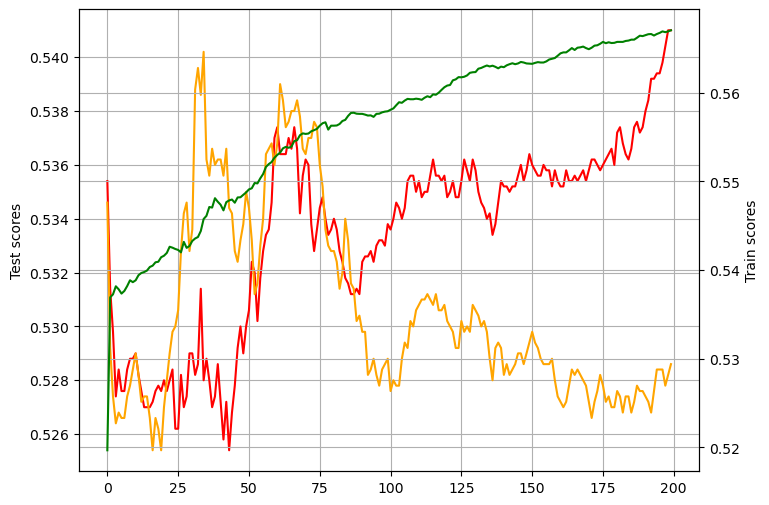

In [23]:
# 加载基本数据

#设置随机数种子
#torch.manual_seed(42)
#torch.manual_seed(50)
torch.manual_seed(65)
#torch.backends.cudnn.deterministic = True
#torch.backends.cudnn.benchmark = False
#gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# 一些参数
start_sample=0
end_sample=205092

# 定义数据导入
def load_data(end_sample):

    # 取出对应时间跨度的X和Y
    x1 = X_hunhe[start_sample:end_sample, :, :]
    x1 = np.nan_to_num(x1, nan=0)
    y = Y[start_sample:end_sample]
    y=np.nan_to_num(y, nan=0)

    x1_in_sample = x1
    mask = np.any(x1_in_sample[:,:,:769] != 0, axis=(1, 2))
    x1_in_sample = x1_in_sample[mask]
    y_in_sample = y
    y_in_sample = y_in_sample[mask]
    print(x1_in_sample.shape)
    print(y_in_sample.shape)    

    split1 = int(y_in_sample.shape[0] * 0.7)
    split2 = int(y_in_sample.shape[0] * 0.95)
    x1_train = x1_in_sample[:47333, :, :]
    x1_val = x1_in_sample[47333:52333, :, :]
    x1_test = x1_in_sample[52333:, :, :]
    y_train = y_in_sample[:47333, :]
    y_val = y_in_sample[47333:52333, :]
    y_test = y_in_sample[52333:, :]


    # 对训练集进行标准化
    x1_train_std = x1_train[:,:,-2:]
    print(x1_train_std.shape)
    med_x1_train = np.mean(x1_train_std, 0)
    mad_x1_train = np.std(x1_train_std, 0)
    x1_train_std = standardize_data(x1_train_std, med_x1_train, mad_x1_train)
    #769
    #x1_train =x1_train[:,:,:769]
    #769[0]
    #x1_train =x1_train[:,:,685:769]   
    #769+ret+amt
    x1_train = np.concatenate((x1_train[:,:,:769], x1_train_std), axis=2)
    #ret
    #x1_train=x1_train_std[:,:,:1]
    #amt
    #x1_train=x1_train_std[:,:,-1:]
    
    # 对验证集进行标准化
    x1_val_std = x1_val[:,:,-2:]
    print(x1_val_std.shape)
    med_x1_val = np.mean(x1_val_std, 0)
    mad_x1_val = np.std(x1_val_std, 0)
    x1_val_std = standardize_data(x1_val_std, med_x1_val, mad_x1_val)
    x1_val = np.concatenate((x1_val[:,:,:769], x1_val_std), axis=2)
    
    #769
    #x1_val =x1_val[:,:,:769]
    #769[0]
    #x1_val =x1_val[:,:,685:769]    
    #769+ret+amt
    x1_val = np.concatenate((x1_val[:,:,:769], x1_val_std), axis=2)
    #ret
    #x1_val=x1_val_std[:,:,:1]
    #amt
    #x1_val=x1_val_std[:,:,-1:]
    
    # 对测试集进行标准化
    x1_test_std = x1_test[:,:,-2:]
    print(x1_test_std.shape)
    med_x1_test = np.mean(x1_test_std, 0)
    mad_x1_test = np.std(x1_test_std, 0)
    x1_test_std = standardize_data(x1_test_std, med_x1_test, mad_x1_test)
    x1_test = np.concatenate((x1_test[:,:,:769], x1_test_std), axis=2)

    #769
    #x1_test =x1_test[:,:,:769]
    #769[0]
    #x1_test =x1_test[:,:,685:769]
    #769+ret+amt
    x1_test = np.concatenate((x1_test[:,:,:769], x1_test_std), axis=2)
    #ret
    #x1_test=x1_test_std[:,:,:1]
    #amt
    #x1_test=x1_test_std[:,:,-1:]
    
    print(x1_train.shape)
    print(x1_val.shape)
    print(x1_test.shape)
    print(y_train.shape)
    print(y_val.shape)
    print(y_test.shape)

    return x1_train, x1_val, x1_test, y_train, y_val, y_test

def CrossEntropyLoss(logits, y_true):
    # x = y_true
    # y = y_pred
    criterion = nn.CrossEntropyLoss()
    loss = criterion(logits, y_true)
    # loss_fn = nn.BCEWithLogitsLoss()
    # loss = loss_fn(y_pred, y_true)
    return loss

BATCH_SIZE = 256
MAX_EPOCH = 200
epoch_iter = 10 #早停轮数设置
w = 0
loss_name = 'CrossEntropy'

# 定义模型训练和测试的方法
def train(train_dl):
    # 模型的训练状态
    acc = 0  # 训练集准确率
    model.train()
    tqdm_ = tqdm(iterable=train_dl)
    
    loss_list = []
    for i, batch in enumerate(tqdm_):
        # 获得一个批次的数据和标签
        x1, labels = batch
        
        x1 = x1.to(device)
        labels = labels.to(device)
        labels = labels.squeeze().long()
        
        #print(labels.shape)
        out = model(x1)
        #print(out.shape)
        # 损失函数
        if loss_name == 'CrossEntropy':
            loss = CrossEntropyLoss(out, labels)
        loss_list.append(loss.item())
        # 梯度清零
        optimizer.zero_grad()
        # 计算梯度
        loss.backward()
        # 修改权值
        optimizer.step()
        #print(out.shape)
        # print(labels.shape)
        acc += (torch.argmax(out, dim=1) == labels).sum().item()
    # tqdm_.set_description("epoch:{:d} train loss:{:.4f}".format(epoch, loss.item()))
    print(f"train acc:{acc / len(y_train)} train_loss:{sum(loss_list) / len(loss_list)}")
    return acc / len(y_train)

def eval(val_dl):
    # 模型的测试状态
    model.eval()
    acc = 0  # 测试集准确率
    tqdm_ = tqdm(iterable=val_dl)
    for i, batch in enumerate(tqdm_):
        # 获得一个批次的数据和标签
        x1, labels = batch
        x1 = x1.to(device)
        labels = labels.to(device)
        labels = labels.squeeze().long()
        out = model(x1)
        #print(out)
        # 预测正确的数量
        acc+= (torch.argmax(out, dim=1) == labels).sum().item() 
        tqdm_.set_description("epoch:{:d} val {!s}:{:.4f} ".format(epoch, loss_name, acc))
    print(f"val acc:{acc / len(y_val)}")
    return acc / len(y_val)

def test(test_dl):
    # 模型的测试状态
    model_test.eval()
    test_acc=0  # 测试集准确率
    tqdm_test = tqdm(iterable=test_dl)
    for i, batch in enumerate(tqdm_test):
        # 获得一个批次的数据和标签
        x1_test, labels_test = batch
        x1_test = x1_test.to(device)
        labels_test = labels_test.to(device)
        labels_test = labels_test.squeeze().long()
        y_pred = model(x1_test)
        #print(out)
        # 预测正确的数量
        test_acc+= (torch.argmax(y_pred, dim=1) == labels_test).sum().item() 
    print(f"test acc:{test_acc / len(y_test)}")
    return test_acc / len(y_test)


if __name__ == '__main__':

    x1_train, x1_val, x1_test,y_train, y_val,y_test = load_data(205092)
    #x1_train, x1_val ,y_train, y_val = load_data(60)    
    print('data finish')

    train_ds = Mydataset(x1_train, y_train)
    train_dl = DataLoader(train_ds, batch_size = BATCH_SIZE)

    val_ds = Mydataset(x1_val, y_val)
    val_dl = DataLoader(val_ds, batch_size = BATCH_SIZE)

    test_ds = Mydataset(x1_test, y_test)
    test_dl = DataLoader(test_ds, batch_size = BATCH_SIZE)
    # 定义模型
    model = MyModel()
    model.to(device)
    # 定义优化器
    #optimizer = optim.Adam(model.parameters(), lr=0.0007)# 随机梯度下降
    #optimizer = optim.SGD(model.parameters(), lr=0.0007, momentum=0.9, nesterov=True, weight_decay=1e-4)
    #optimizer = optim.AdamW(model.parameters(), lr=0.0008)
    optimizer = optim.AdamW(model.parameters(), lr=0.0008, weight_decay=0.05)
    #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1) # 学习率衰减step_size可设置
    #scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=0.001) #热重启学习率
    # 记录学习率和 epoch 数组
    lr_history = []
    epoch_history = []

    max_acc = -10000
    max_epoch = 0
    #记录train_ic数组和ic数组
    train_list = []
    val_list = []
    # 定义保存模型参数的列表和计数器
    test_list=[]
    for epoch in range(MAX_EPOCH):
        train_acc = train(train_dl)
        acc = eval(val_dl)

        train_list.append(train_acc)
        val_list.append(acc)

        if acc > max_acc:
            max_acc = acc
            max_epoch = epoch
            model_path = f'model/gru_model/'
            torch.save(model, model_path + 'gru_model' + '.pt')
        else:
            ...
            #if epoch - max_epoch >= epoch_iter:
            #    break
        # 更新学习率
        #scheduler.step()
        
        # 记录学习率和 epoch
        lr_history.append(optimizer.param_groups[0]['lr'])
        epoch_history.append(epoch)

        # #predict
        model_test = MyModel()
        # 加载模型
        model_path = f'model/gru_model/'
        print('--------------------------------')
        print(model_path + 'gru_model' + '.pt')
        print('--------------------------------')
        model_test = torch.load(model_path +  'gru_model' + '.pt')
        test_acc=test(test_dl)
        test_list.append(test_acc)

    # 创建包含一个子图和共享 x 轴的第二个 y 轴的图形
    fig, ax1 = plt.subplots(figsize=[8, 6])
    ax2 = ax1.twinx()
    # # 绘制学习率随时间的变化折线图
    # ax1.plot(epoch_history, lr_history, label='learning_rate', color='blue')
    # ax1.set_xlabel('Epoch')
    # ax1.set_ylabel('Learning rate')
    # ax1.set_title('Learning rate and scores')
    # ax1.tick_params(axis='y', labelcolor='blue')
    # 绘制验证分数的折线图
    ax1.plot(np.arange(epoch + 1), val_list, label='valid_scores', color='red')
    ax1.set_ylabel('Valid scores')
    ax1.tick_params(axis='y', labelcolor='black')
    # 绘制test分数的折线图
    ax1.plot(np.arange(epoch + 1), test_list, label='test_scores', color='orange')
    ax1.set_ylabel('Test scores')
    ax1.tick_params(axis='y', labelcolor='black')
    # 绘制训练分数的折线图
    ax2.plot(np.arange(epoch + 1), train_list, label='train_scores', color='green')
    ax2.set_ylabel('Train scores')
    ax2.tick_params(axis='y', labelcolor='black')
    # # 绘制验证分数的折线图
    # ax2.plot(np.arange(epoch + 1), val_list, label='valid_scores', color='red')
    # ax2.set_ylabel('Valid scores')
    # ax2.tick_params(axis='y', labelcolor='black')
    # # 绘制test分数的折线图
    # ax2.plot(np.arange(epoch + 1), test_list, label='test_scores', color='orange')
    # ax2.set_ylabel('Test scores')
    # ax2.tick_params(axis='y', labelcolor='black')
    
    # 添加网格线
    ax1.grid(True)
    ax2.grid(True)
    # 显示图形
    plt.show()
